https://www.kaggle.com/datasets/dipankarsrirag/topic-modelling-on-emails

In [1]:
#-------------------------------------Boiler Plate Imports---------------------------------------------------------#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#---------------------------------------Text Processing------------------------------------------------------------#
import regex
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
#------------------------------------Metrics and Validation---------------------------------------------------------#
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
#-------------------------------------Models to be trained----------------------------------------------------------#
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import xgboost
#########################################################################

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Input dan Read Dataset

In [7]:
names = []
base = '/content/drive/MyDrive/TextClassification-Ensemble/Data/'
with os.scandir(base) as entries:
    for entry in entries:
        if(entry.is_file() == False):
            names.append(entry.name)
names.sort()

In [8]:
files = {}
unique = []
for name in names:
    path = base + name+'/'
    x = []
    with os.scandir(path) as entries:
        for entry in entries:
            if(entry.is_file()):
                x.append(entry.name)
    files[name] = x
    files[name].sort()

In [9]:
for i in range(len(names)):
    x = files[names[i]]
    for j in x:
        for k in range(i+1, len(names)):
            key = names[k]
            if j in files[key]:
                files[key].remove(j)

In [10]:
data = {}
i = 0

for genre in files.keys() :
    texts = files[genre]
    for text in texts:
        if text in files[genre]:
            path = base + genre + '/' + text
            with open(path, "r", encoding = "latin1") as file:
                data[i] = file.readlines()
                i = i+1
            data[i-1] = [" ".join(data[i-1]), genre] 

data = pd.DataFrame(data).T
print(data.shape)
data.columns = ['Text', 'Class']

(6734, 2)


In [11]:
unique = list(data.Text.unique())
len(unique)

6581

In [12]:
dic = dict(data)

In [13]:
uni = {}
i = 0
for k in range(len(list(dic['Text']))):
    if dic['Text'][k] in unique:
        uni[i] = [dic['Text'][k], dic['Class'][k]]
        unique.remove(dic['Text'][k])
        i += 1

In [14]:
data = pd.DataFrame(uni).T
print(data.shape)
data.columns = ['Text', 'Class']

(6581, 2)


# Function untuk Preproses Data

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')

for punct in punctuation:
    stop.append(punct)

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha() and len(w) > 3]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

In [23]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
data["filtered_text"] = data.Text.apply(lambda x : filter_text(x, stop)) 
data.head()

,Text,Class,filtered_text
0,"\n Archive-name: ripem/faq\n Last-update: Sun,...",Crime,archive name ripem last update post still rath...
1,Approved: news-answers-request@MIT.EDU\n Conte...,Crime,approve news answer request content type text ...
2,Approved: news-answers-request@MIT.EDU\n Conte...,Crime,approve news answer request content type text ...
3,Message-ID: <1ppvai$l79@bilbo.suite.com>\n Rep...,Crime,message bilbo suite reply miller suite nntp po...
4,\n Some sick part of me really liked that p...,Crime,sick part really like phrase actually merely t...


### Crime

Top 10 words in the Crime Category

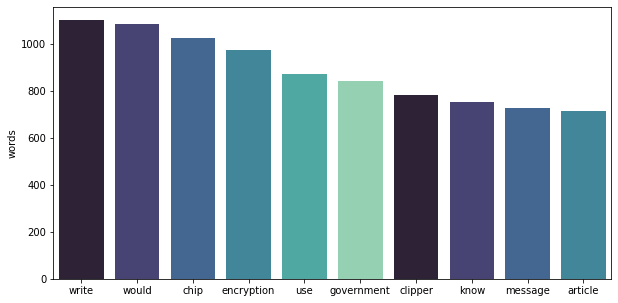

In [25]:
all_text = " ".join(data[data.Class == "Crime"].filtered_text) 
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:10].index[:10]))]
plt.figure(figsize=(10,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

## Politics

Top 10 words in the Politics Category

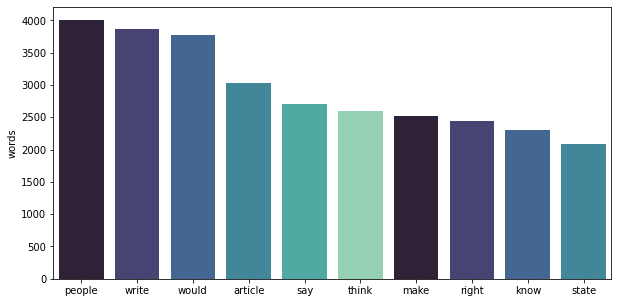

In [26]:
all_text = " ".join(data[data.Class == "Politics"].filtered_text)
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:10].index[:10]))]
plt.figure(figsize=(10,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

## Science

Top 10 words in the Science Category


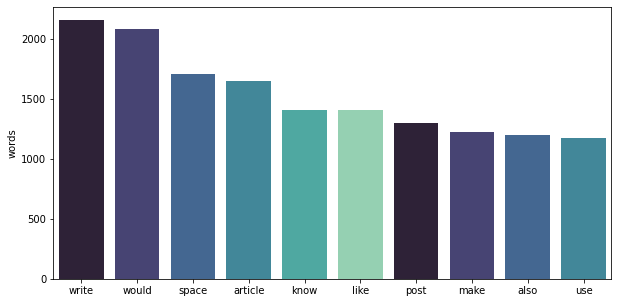

In [27]:
all_text = " ".join(data[data.Class == "Science"].filtered_text)
count = pd.DataFrame(all_text.split(), columns = ['words'])
top_10 = count[count['words'].isin(list(count.words.value_counts()[:10].index[:10]))]
plt.figure(figsize=(10,5))
sns.barplot(x = top_10.words.value_counts().index,
            y = top_10.words.value_counts(), palette = sns.color_palette("mako"))

# Konversi ke vektor untuk text yang sudah terfilter

In [28]:
tfidf = TfidfVectorizer(lowercase=False)
train_vec = tfidf.fit_transform(data['filtered_text'])
train_vec.shape

(6581, 43129)

In [29]:
data['classification'] = data['Class'].replace(['Crime','Politics','Science'],[0,1,2])

In [30]:
x_train, x_val, y_train, y_val = train_test_split(train_vec,data['classification'], stratify=data['classification'], test_size=0.2)

# Model untuk training

> Base Model:
* Logistic Regression with RandomizedSearchCV.
* Multinomial Naive Bayes with RandomizedSearchCV.
* SDGClassifier with Hinge Loss -> SVM.
* Decision Tree Classifier
* KNeighbors Classifier
* XGBClassifer

> Ensemble dengan:
* Hard Voting Classifier.
* Stacking Classifier with XGBClassifier as the "final estimator" or "meta learner".

## Logistic Regression with RandomizedSearchCV

In [31]:
C = np.arange(0, 1, 0.001)
max_iter = range(100, 500)
warm_start = [True, False]
solver = ['lbfgs', 'newton-cg', 'liblinear']
penalty = ['l2', 'l1']

params = {
    'C' : C,
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'penalty' : penalty
}

random_search = RandomizedSearchCV(
    estimator = LogisticRegression(random_state = 1),
    param_distributions = params,
    n_iter = 100,
    cv = 3,
    n_jobs = -1,
    random_state = 1,
    verbose = 1
).fit(x_train, y_train)

random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
117 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

{'warm_start': False,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'max_iter': 486,
 'C': 0.982}

In [32]:
model_lr = random_search.best_estimator_
model_lr.score(x_train, y_train)

0.9772036474164134

Test score: 0.94
Cohen Kappa score: 0.90


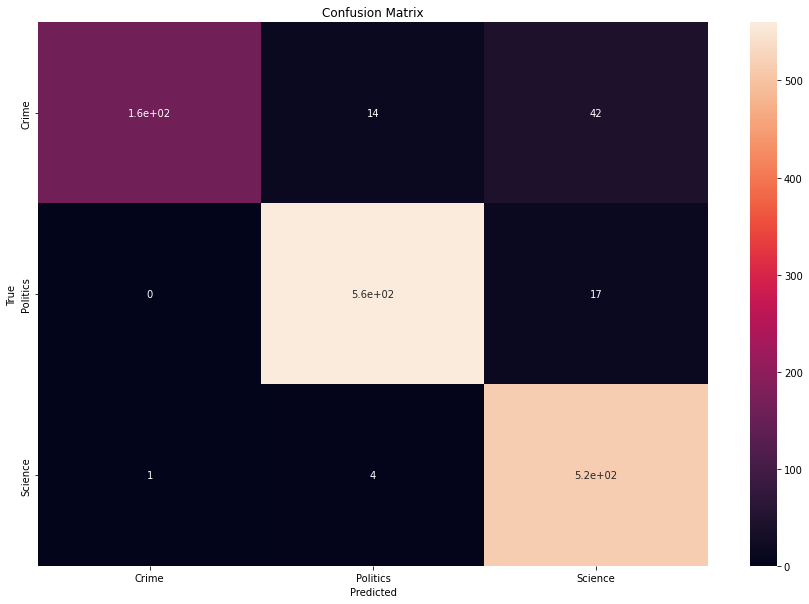

In [33]:
predicted = model_lr.predict(x_val)

lr_acc = accuracy_score(y_val,predicted)
lr_cop = cohen_kappa_score(y_val,predicted)
lr = pd.DataFrame([lr_acc, lr_cop], columns = ['Logistic Regression with RandomizedSearchCV'])

print("Test score: {:.2f}".format(lr_acc))
print("Cohen Kappa score: {:.2f}".format(lr_cop))

plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## Multinomial Naive Bayes with RandomizedSearchCV

In [34]:
alpha = np.arange(0, 1, 0.001)
fit_prior = [True, False]

params = {
    'alpha' : alpha,
    'fit_prior' : fit_prior
}

random_search = RandomizedSearchCV(
    estimator = MultinomialNB(),
    param_distributions = params,
    n_iter = 100,
    cv = 3,
    n_jobs = -1,
    random_state = 1,
    verbose = 1
).fit(x_train, y_train)

random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'fit_prior': True, 'alpha': 0.024}

In [35]:
model_mnb = random_search.best_estimator_
model_mnb.score(x_train, y_train)

0.9943009118541033

Test score: 0.96
Cohen Kappa score: 0.94


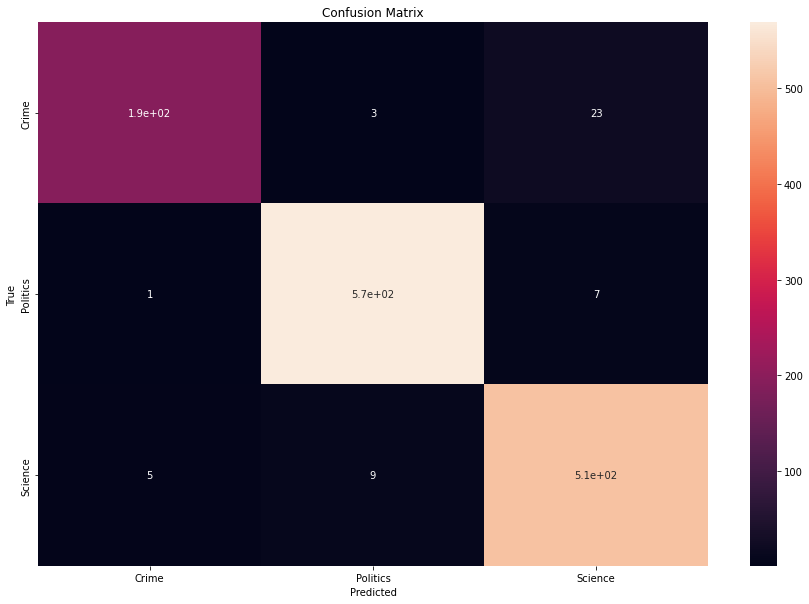

In [36]:
predicted = model_mnb.predict(x_val)

mnb_acc = accuracy_score(y_val,predicted)
mnb_cop = cohen_kappa_score(y_val,predicted)
mnb = pd.DataFrame([mnb_acc, mnb_cop], columns = ['MultinomialNB with RandomizedSearchCV'])

print("Test score: {:.2f}".format(mnb_acc))
print("Cohen Kappa score: {:.2f}".format(mnb_cop))

plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## SGDClassifier with Squared Hinge Loss

In [37]:
model_sgd_hinge = SGDClassifier(
    loss='squared_hinge',
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=1,
    epsilon=0.1,
    n_jobs=-1,
    random_state=1,
    learning_rate='optimal',
    eta0=0.0,
    power_t=0.5,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    warm_start=False,
    average=False).fit(x_train, y_train)

model_sgd_hinge.score(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 1878.43, NNZs: 14105, Bias: -6.584713, T: 5264, Avg. loss: 98.075397
Norm: 1032.96, NNZs: 11676, Bias: -12.909489, T: 5264, Avg. loss: 29.053818Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 1029.99, NNZs: 15259, Bias: -4.640437, T: 10528, Avg. loss: 6.056100
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 707.10, NNZs: 15478, Bias: -4.681222, T: 15792, Avg. loss: 0.049846Norm: 571.45, NNZs: 13614, Bias: -9.798646, T: 10528, Avg. loss: 3.001282
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 393.57, NNZs: 13750, Bias: -8.793793, T: 15792, Avg. loss: 0.267118
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 538.59, NNZs: 15804, Bias: -4.339337, T: 21056, Avg. loss: 0.005158
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 300.86, NNZs: 13837, Bias: -8.102932, T: 21056, Avg. loss: 0.043995
Total training time: 0.06 seconds.
-- Epoch 5

Total training time: 0.07 seconds.Norm: 435.07, NNZs: 15935,

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9996200607902735

Test score: 0.94
Cohen Kappa score: 0.90


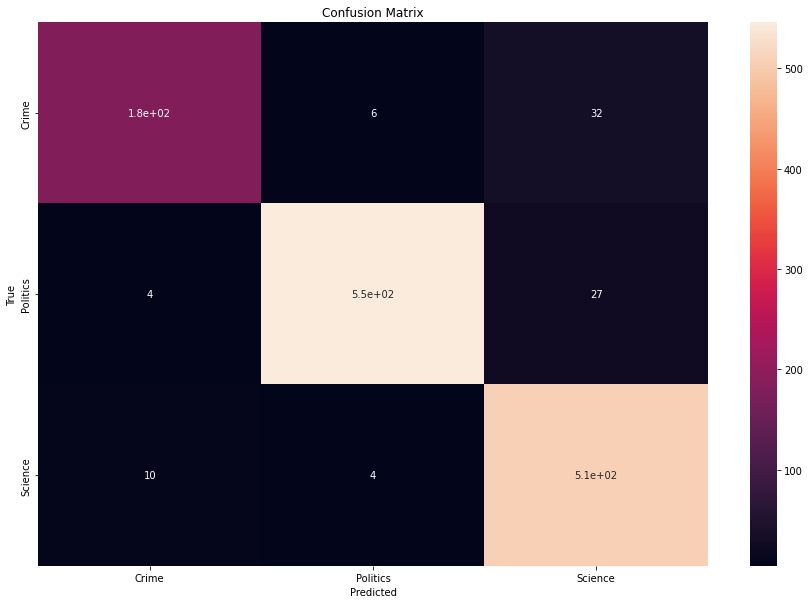

In [38]:
predicted = model_sgd_hinge.predict(x_val)

sgd_hinge_acc = accuracy_score(y_val,predicted)
sgd_hinge_cop = cohen_kappa_score(y_val,predicted)
sgd_hinge = pd.DataFrame([sgd_hinge_acc, sgd_hinge_cop], columns = ['SGDClassifier with Squared Hinge Loss'])

print("Test score: {:.2f}".format(sgd_hinge_acc))
print("Cohen Kappa score: {:.2f}".format(sgd_hinge_cop))
plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## Decision Tree Classifier with RandomizedSearchCV

In [39]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = range(5, 200)
max_features = ['auto', 'sqrt', 'log2']

params = {
    'criterion' : criterion,
    'splitter' : splitter,
    'max_depth' : max_depth,
    'max_features' : max_features
}

random_search = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(random_state = 1),
    param_distributions = params,
    n_iter = 100,
    cv = 3,
    n_jobs = -1,
    random_state = 1,
    verbose = 1
).fit(x_train.toarray(), y_train)

random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'splitter': 'random',
 'max_features': 'sqrt',
 'max_depth': 184,
 'criterion': 'gini'}

In [40]:
model_dt = random_search.best_estimator_
model_dt.score(x_train.toarray(), y_train)

0.9713145896656535

Test score: 0.71
Cohen Kappa score: 0.53


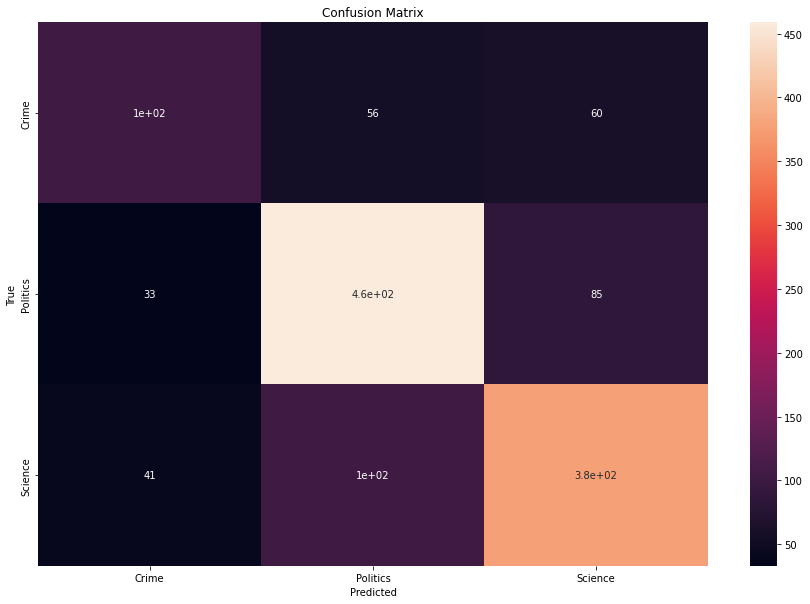

In [41]:
predicted = model_dt.predict(x_val.toarray())

dt_acc = accuracy_score(y_val,predicted)
dt_cop = cohen_kappa_score(y_val,predicted)
dt = pd.DataFrame([dt_acc, dt_cop], columns = ['DecisionTreeClassifier with RandomizedSearchCV'])

print("Test score: {:.2f}".format(dt_acc))
print("Cohen Kappa score: {:.2f}".format(dt_cop))
plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## KNeighborsClassifier with RandomizedSearchCV

In [43]:
n_neighbors = range(5, 100)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = range(30, 100)
p = range(1, 4)

params = {
    'n_neighbors' : n_neighbors,
    'weights' : weights,
    'algorithm' : algorithm,
    'leaf_size' : leaf_size,
    'p'  : p
}

random_search = RandomizedSearchCV(
    estimator = KNeighborsClassifier(n_jobs = -1),
    param_distributions = params,
    n_iter = 100,
    cv = 3,
    n_jobs = -1,
    random_state = 1,
    verbose = 1
).fit(x_train, y_train)

random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
84 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 513, in _fit
    "Metric can also be a callable function." % (self.effective_metric_)
ValueError: Metric '

{'weights': 'distance',
 'p': 2,
 'n_neighbors': 17,
 'leaf_size': 74,
 'algorithm': 'brute'}

In [44]:
model_kn = random_search.best_estimator_
model_kn.score(x_train, y_train)

0.9998100303951368

Test score: 0.93
Cohen Kappa score: 0.89


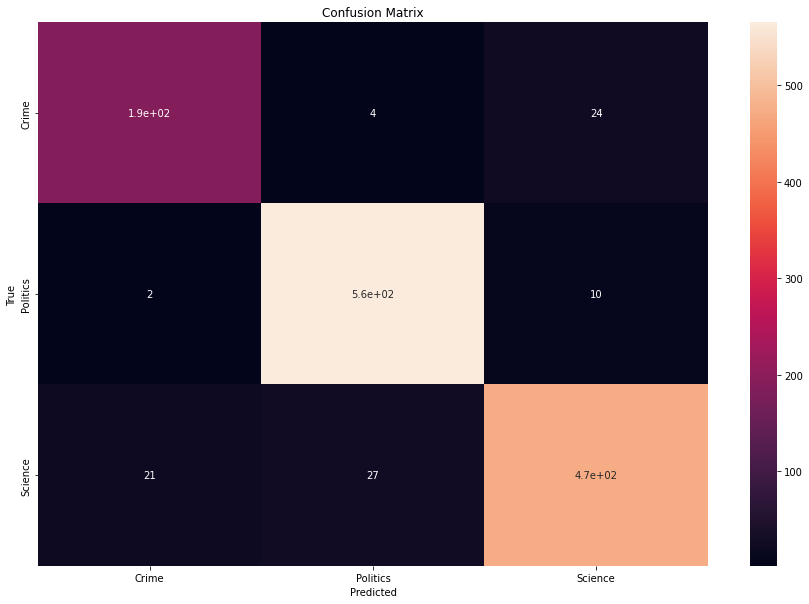

In [45]:
predicted = model_kn.predict(x_val)

kn_acc = accuracy_score(y_val,predicted)
kn_cop = cohen_kappa_score(y_val,predicted)
kn = pd.DataFrame([kn_acc, kn_cop], columns = ['KNeighborsClassifier with RandomizedSearchCV'])

print("Test score: {:.2f}".format(kn_acc))
print("Cohen Kappa score: {:.2f}".format(kn_cop))
plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## Ensemble Methods

In [46]:
estimators = [
    ('kn', model_kn),
    ('mnb', model_mnb),
    ('lr', model_lr),
    ('dt', model_dt)
]

estimators

[('kn',
  KNeighborsClassifier(algorithm='brute', leaf_size=74, n_jobs=-1, n_neighbors=17,
                       weights='distance')),
 ('mnb', MultinomialNB(alpha=0.024)),
 ('lr', LogisticRegression(C=0.982, max_iter=486, random_state=1)),
 ('dt',
  DecisionTreeClassifier(max_depth=184, max_features='sqrt', random_state=1,
                         splitter='random'))]

## Soft Voting Classifier

In [47]:
model_voting = VotingClassifier(
    estimators = estimators,
    voting='soft', 
    n_jobs=-1,
    flatten_transform=True, 
    verbose=1).fit(x_train, y_train)

model_voting.score(x_train, y_train)

0.998290273556231

Test score: 0.95
Cohen Kappa score: 0.92


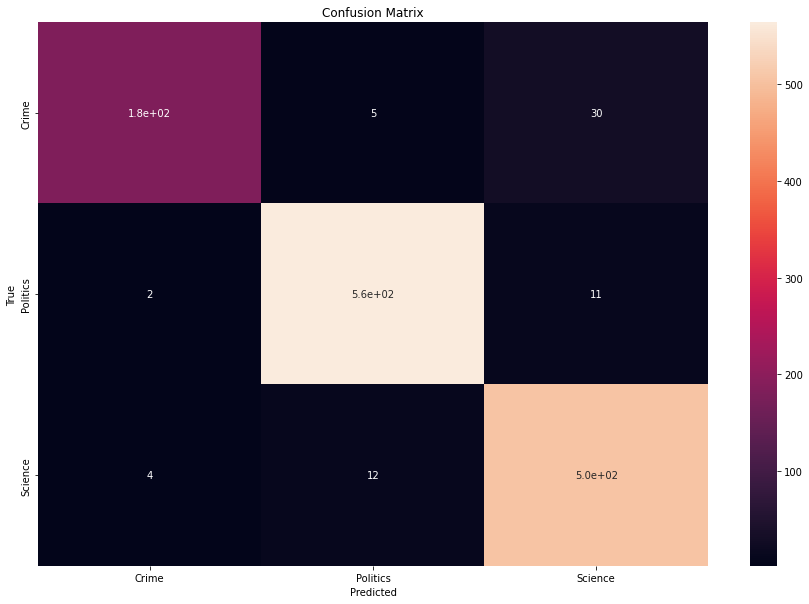

In [48]:
predicted = model_voting.predict(x_val)

voting_acc = accuracy_score(y_val,predicted)
voting_cop = cohen_kappa_score(y_val,predicted)
voting = pd.DataFrame([voting_acc, voting_cop], columns = ['Soft Voting Classifier'])

print("Test score: {:.2f}".format(voting_acc))
print("Cohen Kappa score: {:.2f}".format(voting_cop))

plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

## Stacking Classifier

In [49]:
xgc = xgboost.XGBClassifier()

model_stack = StackingClassifier(
    estimators=estimators+[('svm', model_sgd_hinge)],
    final_estimator=xgc,
    n_jobs = -1,
    verbose = 1
)

model_stack.fit(x_train, y_train)

model_stack.score(x_train, y_train)

0.9984802431610942

Test score: 0.97
Cohen Kappa score: 0.94


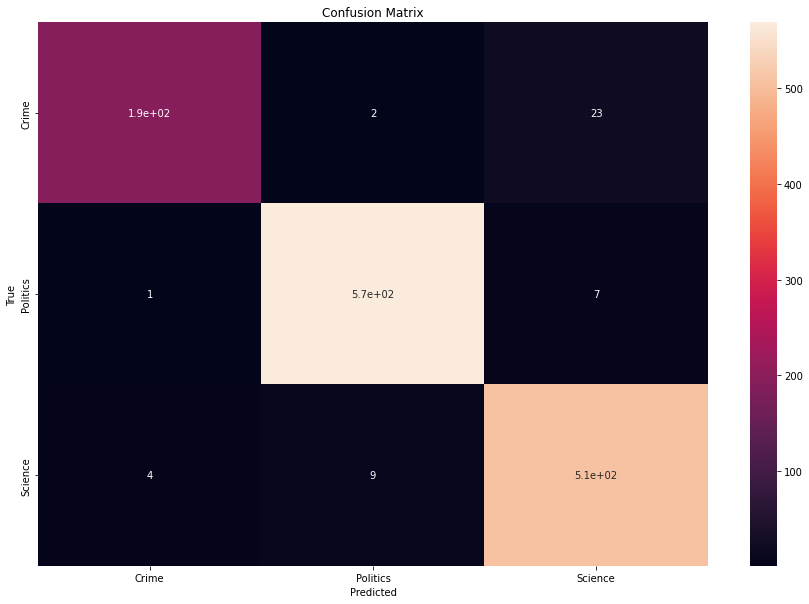

In [50]:
predicted = model_stack.predict(x_val)

stack_acc = accuracy_score(y_val,predicted)
stack_cop = cohen_kappa_score(y_val,predicted)
stack = pd.DataFrame([stack_acc, stack_cop], columns = ['Stacking Classifier'])

print("Test score: {:.2f}".format(stack_acc))
print("Cohen Kappa score: {:.2f}".format(stack_cop))

plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_val,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['Crime','Politics','Science']),
            yticklabels=(['Crime','Politics','Science']))

# Model Comparision

In [51]:
model_comp = pd.concat([lr, mnb, sgd_hinge, dt, kn, voting, stack], axis = 1)
model_comp

,Logistic Regression with RandomizedSearchCV,MultinomialNB with RandomizedSearchCV,SGDClassifier with Squared Hinge Loss,DecisionTreeClassifier with RandomizedSearchCV,KNeighborsClassifier with RandomizedSearchCV,Soft Voting Classifier,Stacking Classifier
0,0.940774,0.963554,0.936978,0.712225,0.933181,0.951405,0.965072
1,0.903588,0.941243,0.898418,0.532253,0.892648,0.921459,0.943694


# Testing ke data yang belum pernah dilatih

In [52]:
#Politics##################################################################################################################################################################################################################################################################################################################################
text_1 = """
With visa office closures and international travel restrictions still in place, experts say the economic benefits of President Donald Trump’s immigration suspension last week are uncertain, at best, while thousands of prospective immigrants still stand to suffer the consequences.

Although the suspension was filled with broad exemptions and does not include current visa holders or those already in the U.S., the Migration Policy Institute estimates 26,000 would-be green card applicants would be blocked each month.

Over the weekend, a coalition of advocacy groups filed an emergency request to halt Trump’s directive. It was the latest move in a 2019 case, stemming from when the White House sought to ban immigrants who couldn’t prove their ability to acquire.
Attorneys with the American Immigration Lawyers Association requested a hold on the recent suspension order while the courts continue to decide the fate of the health insurance restrictions.

The White House framed the immigration suspension as a vital component of helping the economy and American workers recover, but it could have the opposite effect.

Immigrants already in the U.S. and those who already have certain visas can still obtain permanent residency. The suspension applies only to green card applicants from outside the country and primarily targets to those looking to settle down in the U.S. permanently through a family connection, according to MPI estimates.

That leaves the possibility of employment-based visa slots opening up as a result of the suspension.

"President Trump claims he signed it in order to protect the economy in the wake of the coronavirus outbreak, but the reality is that our economic recovery will depend on immigrants," said Esther Sung, a senior attorney involved in the 2019 case.

That view is shared, in part, by Rutgers economics professor Jennifer Hunt. She told ABC News that an influx of workers into critical sectors of the economy could boost per capita GDP.

"It would be kind of a shot in the arm," Hunt said.

On-going travel restrictions and the closure of foreign visa offices still pose the greatest barrier to legal immigration in the age of coronavirus. Economists and labor experts, including Hunt, say those factors would override any attempt to assess the economic impacts of the restrictions.

"It’s very hard for me to see the direct correlation in terms of immediate and practical positive impact on displaced U.S. workers," said Caroline Tang, an Austin-based attorney who advises companies on work authorization for immigrants.

Tang said the bar for employers to obtain work authorization for visa holders is already high enough, referring to specific requirements for prioritizing U.S. citizens.

Researchers have identified some connection between more immigrants settled in the country and economic growth under normal circumstances, but the results are mixed.

For example, a 2017 report by the economics firm Moody Analytics and ProPublica found that for every 1% increase in the U.S. population, the gross domestic product rises by 1.5%. While a 2018 study from Stanford University’s Hoover Institution confirms that "positive relationship" generally, but found variations and some negative impacts to U.S.-born employment rates in its state-by-state review.

Researchers studying the large population of foreign-born workers in South Africa said it likely had a positive impact on per capita GDP.

"Foreign-born workers also generated additional employment for native-born workers," according to the 2018 Organisation for Economic Co-operation and Development report.

"""

# Politics##################################################################################################################################################################################################################################################################################################################################

text_2 = """Disputes have already broken out within the new political alliance that is working to end 36 years of rule by the Socialist Party (PSOE) in Spain’s southern region of Andalusia.

Just hours after the far-right Vox agreed to support the Popular Party (PP)’s candidate to head the region, Juan Manuel Moreno, its demand for a specific regional department for family affairs is running into opposition from Ciudadanos (Citizens), the third party involved in the government change.

These early clashes suggest it could be difficult to export the model to other parts of Spain

The PP and the liberal Ciudadanos have reached their own governing agreement in the wake of an election that undermined the Socialists’ hold on power, but they need support from Vox’s 12 newly elected lawmakers to make it a reality.

Ciudadanos has refused point-blank to meet with Vox representatives, but the PP has struck its own parallel deal with the far right to ensure its support at the investiture debate, which will take place on January 15 and 16.

On Friday morning, Juan Marín of Ciudadanos said that there are no plans for a separate family affairs department within the government structure they have devised with their PP partners, and which does not include Vox.

The reform party has insisted that the Vox-PP deal does not affect them at all, and Ciudadanos’ national leader, Albert Rivera, said on Thursday that Vox “has had to take a step back, correct itself, and sheathe its sword,” alluding to the fact that Vox has dropped some of its most radical demands such as the deportation of 52,000 undocumented migrants.

 Vox national leader Santiago Abascal (c) and Andalusian leader Francisco Serrano (r).
Vox national leader Santiago Abascal (c) and Andalusian leader Francisco Serrano (r). REUTERS
But Vox insists on a family department, and said it will expect loyalty from the PP on this issue. Meanwhile, Ciudadanos has also warned it will not support the PP-Vox proposal to change the historical memory law for a “concord law.”

These early clashes suggest it could be difficult to export the model to other parts of Spain, where local and regional elections are scheduled to be held this year. The PP president, Pablo Casado, said on Thursday that their separate deals with Ciudadanos and Vox in Andalusia are “a preamble of what’s going to happen in May in Spain.”

The PP is anxious to win back power in regions like Valencia, the Balearic Islands, Castilla-La Mancha, Aragón and Cantabria, and to retain it in Madrid, Murcia, La Rioja and Castilla y León.

Parliamentary debate
The PSOE has already digested the fact that it is losing its hold on Spain’s most populated region. “We will conduct a responsible opposition, and remain vigilant about defending self-government and Andalusia’s presence in Spain,” said the party’s parliamentary spokesman, Mario Jiménez.

The Socialists will not be putting forward a candidate, now that the PP nominee has enough support for an absolute majority in the first round. The debates will take place on January 15 and 16, followed by a vote, said Speaker Marta Bosquet.

The sum of the PP, Ciudadanos and Vox votes is four above the 55 required for a majority. The PSOE lost 14 seats at the December 2 election, down to 33. The Podemos-backed Adelante Andalucía has 17 lawmakers.

"""
# Health##################################################################################################################################################################################################################################################################################################################################

text_3 = """


SUBSCRIBE


GO

HEALTH NEWS
Fact Checked
These Foods Can Increase Your Alzheimer’s Risk


Share on Pinterest
A sugar, highly processed foods and starchy foods may increase risk of developing Alzheimer’s disease. Getty Images
A diet mixing sugary snacks, starchy foods, and processed meat may significantly increase risk of developing Alzheimer’s disease.
The study looked at over 200 people with an average age of 78 living with dementia and compared them with a group of 418 in the same age range without the condition.
It wasn’t the amount of “unhealthy” food that seemed to increase dementia risk, but instead the absence of other healthier foods.
Researchers find it’s not just what you eat, but also how foods are combined that may increase your risk of Alzheimer’s and other forms of dementia.

A new study suggests that mixing sugary snacks, starchy foods, and processed meat may significantly increase the risk of developing Alzheimer’s disease. The findings are published in Neurology, the medical journal of the American Academy of Neurology.

“People who developed dementia were more likely to combine highly processed meats with starchy foods like potatoes, alcohol, and snacks like cookies and cakes,” study author Cecilia Samieri, PhD, of the University of Bordeaux in France, told Healthline. “In spite of not being consumed in higher quantity, processed meat appeared very central in their diet, that is, connected with many foods.”

The study looked at over 200 people with an average age of 78 living with dementia and compared them with a group of 418 in the same age range without the condition.

All participants received a medical checkup every 2 to 3 years and completed food questionnaires recording what foods they ate and how frequently for the previous 5 years.

Diet in midlife may influence brain disease risk
Researchers analyzed data from the food questionnaires to compare what foods were frequently eaten together by those with and without dementia.

Samieri points out they could only draw conclusions from a narrow age range.

“The main limitation is the use of a single dietary survey,” she said. “We know that diet over time, starting in midlife and probably even before, likely influences the risk of brain diseases later in life. Here, we had an evaluation of diet after age 65 only.”

Also, it wasn’t the amount of “unhealthy” food that seemed to increase the risk of dementia, but instead, not eating other healthier foods, suggest the findings.

Samieri pointed out that in this kind of study, the assumption was that “the diet people adopt at this age is a good representation of the diet followed over the years preceding the interview.”

Another limitation was that diets were recorded only once, years before the onset of dementia, so changes in diet over time were unknown.
"""

# Entertainment##################################################################################################################################################################################################################################################################################################################################

text_4 = """
Cádiz is in style: it has just been included in The New York Times’ list of 52 Places to Go in 2019. The recognition comes on the back of acknowledgment from TripAdvisor, which last year ranked Cádiz eighth on its list of European Destinations On The Rise for 2018.

The journalist Andrew Ferren, who wrote about Cádiz for The New York Times’ list, lives in Spain himself and is no stranger to the southern province’s charms. “I am fascinated by its mix of atmospheres,” he says. “You leap from places as sophisticated and cultured as Jerez de la Frontera to wild landscapes that take your breath away, such as the beach in Bolonia or Alcornocales Park. It’s like the Wild West of southern of Spain.”

“Despite the fact that Cádiz was historically a major maritime link between America and Europe, it’s not very well known to the US public and it’s really worth a visit,” he adds. There are three main reasons why The New York Times recommends a trip to Cádiz:

Culinary delights
 Aponiente restaurant in El Puerto de Santa María.
Aponiente restaurant in El Puerto de Santa María.
Suggestions include the new Western-style gastrobar Saja River, recently opened on Santa Elena street, and Código de Barra in La Candelaria Square. Ferren also suggests crossing the bay from the capital to Puerto de Santa María, where Angel León has his three-starred Michelin restaurant offering “a lyrical poem of seafood.” Just 40 km from here, León has another restaurant within the Meliá Sancti Petri hotel called Alevante, which has just been awarded its first Michelin star. For something more casual, there is La Taberna del Chef del Mar, another of the chef’s brands in El Puerto.

To these suggestions, EL VIAJERO adds several of its own, including Restaurante Café Royalty, which opened opened in 1912, and the bookshop café La Clandestina (José del Toro, 23), which serves scrumptious breakfasts. There is also La Candela (Feduchy, 13) for tapas, while an exquisite combo of Andalusian and Norwegian fare is served at Patría restaurant, located on the hillside of Muela in Vejer de la Frontera.

Jerez de la Frontera and its wineries
 Bodegas Lustau, en Jerez de la Frontera (Cádiz).ampliar foto
Bodegas Lustau, en Jerez de la Frontera (Cádiz). NEIL FARRIN GETTY IMAGES
Around 36 km to the north of Cádiz lies Jerez de la Frontera, known for the fortified wines known in English as sherry. Wineries from the region known as Marco de Jerez (comprising Jerez proper, El Puerto and Sanlúcar) preserve their unique 18th and 19th-century atmosphere. Ferren recommends Díez-Mérito, Lustau and Bodegas Tradición. Foodies are told to seek out Lú in Jerez, owned by the chef JuanLu Fernández

The NMAC Montenmedio Foundation
 Vejer de la Frontera.ampliar foto
Vejer de la Frontera. GETTY IMAGES
The NMAC Montenmedio Foundation of contemporary art sits between Barbate and Vejer de la Frontera. It is a private gallery exhibiting works by artists who are asked to come up with projects inspired by the local history and landscape. The center has work by Olafur Eliasson, James Turrell, Marina Abramovic, Pascale Marthine Tayou, Maurizio Cattelan and Santiago Sierra.

EL VIAJERO expands on Ferren’s recommendations with a few of its own:

1.The Cádiz Carnival
 The Cádiz carnival.ampliar foto
The Cádiz carnival.
An unique and fun festival that takes place from February 28 to March 10. In fact it is so unique that it is applying to be included on the World Intangible Cultural Heritage list.

2. Barrio del Pópulo
 The Pópulo neighborhood.ampliar foto
The Pópulo neighborhood. RAQUEL M. CARBONELL GETTY
This is the oldest neighborhood in Cádiz and features an old Roman theater, the old cathedral and stone arches that lead to bohemian bars such as Pay Pay (Silencio, 1), a former brothel that now has live music, dance, improv and stand-up comedy.

3. Cádiz à la Havana
 Cathedral square in Cádiz.ampliar foto
Cathedral square in Cádiz. RAQUEL M. CARBONELL GETTY
Stroll from the colonial-style Mina Square, with its ficus and palm trees, to the Provincial Museum containing Phoenician sarcophagi, to Campo del Sur avenue which was converted into a Havana esplanade for the 2002 James Bond movie Die Another Day.

4. A wealth of history
 Baelo Claudia Roman site in Tarifa (Cádiz).ampliar foto
Baelo Claudia Roman site in Tarifa (Cádiz). KEN WELSH GETTY
Standing on the frontier between two continents, the province of Cádiz has a long and action-packed history, while its capital is one of the oldest cities in Europe. Remnants of yesteryear can be seen at a number of archeological sites, including Baelo Claudia, Carteia and Doña Blanca.

5. Sanlúcar de Barrameda
 Summer beach horse races in Sanlúcar de Barrameda.ampliar foto
Summer beach horse races in Sanlúcar de Barrameda. JUAN CARLOS TORO
Famous for its summer horse racing on the beach as well as for its wineries, this coastal town has been described by journalist Mariló García as a “dazzling city in Cádiz that boasts history, exquisite seafood, a city center with a mix of palaces and wineries as well as the incomparable landscape of Doñana Natural Park.”

6. Coast and mountains
 Olvera, a white village in Cádiz.ampliar foto
Olvera, a white village in Cádiz. RUDI SEBASTIAN GETTY
Cádiz has miles of windswept beaches that make it a perfect haunt for surfers of various descriptions. In less than an hour, however, you can be in the hills visiting quintessentially Andalusian white villages such as Medina Sidonia, Grazalema and Ubrique.

7. The flamenco route
Located in San Fernando, the Peña Flamenca Camarón de la Isla, named after the famous singer, has shows every week and is a good place to tune into some authentic flamenco artistry.

8. Conil de la Frontera
 The beach in Conil de la Frontera.ampliar foto
The beach in Conil de la Frontera. GETTY IMAGES
There are three national parks that stretch along Cádiz’s Atlantic coast – La Breña, Los Alcornocales and el Estrecho – as well as beaches such as Conil de la Frontera which has the best beach bars around for watching the sun go down.

9. Surfing in Tarifa
In the inlets of Los Lances and Valdevaqueros in Tarifa, wind and kitesurfers can skid across the water with a view of Africa in front and El Estrecho national park behind them.

10. The white villages
Nineteen districts in the Cádiz mountains take you through a string of white villages – Alcalá del Valle, Algar, Algodonales, Arcos de la Frontera, Benaocaz, Bornos, El Bosque, Espera, El Gastor, Grazalema, Olvera, Prado del Rey, Puerto Serrano, Setenil de las Bodegas, Torre Alhaquine, Ubrique, Villaluenga del Rosario, Villamartín and Zahara de la Sierra. The villagers still whitewash their homes with lime as they did in the past, normally once a year before the local fiestas.

"""
# Business##################################################################################################################################################################################################################################################################################################################################

text_5 = """
Private banks may sell shares to raise a cumulative Rs 35,000 crore to build a buffer against the economic shocks due to the coronavirus pandemic.
Bank of Baroda, RBL Bank, IndusInd Bank, Yes Bank, Kotak Mahindra Bank and IDFC First Bank are looking to build a “capital base” against the economic effects of COVID-19. RBL and IDFC First plan to raise between Rs 1,800-2,000 crore each, sources told Mint.
IDFC First Bank will reportedly use the capital for “strengthening the bank’s capital buffers further and for growth”.
Moneycontrol could not independently verify the report.
RELATED NEWS
Tobacco smoking potential risk factor for COVID-19: Study
Most Americans cannot or will not use COVID-19 contact tracing apps: Poll
India's January-March gold demand falls 36% due to volatile prices, economic uncertainties: WGC
RBL Bank is also said to be looking to add growth capital and strengthen its capital position.
Follow our LIVE Updates on the coronavirus pandemic here
“The capital raising may happen when the share price goes up. The money can be used for consolidation such as acquisitions or mergers, apart from improving the bank’s tier 1 capital further," sources told the paper.
Over the past weeks, these banks have made plans to issue fresh shares to enhance common equity tier 1 (CET 1) capital, it added. CET 1 is used to measure a bank’s capability to bear loan losses and write-offs, and also measure cash reserve for acquisitions or infusions.
The lockdown to combat the spread of the virus has made it difficult for borrowers to repay loans and could increase slippages and loan write-offs in the September quarter. The second phase of the country-wide lockdown is scheduled to be lifted in phases from May 3.

"""
# Tech##################################################################################################################################################################################################################################################################################################################################

text_6 = """
Elon Musk told the world in late 2017 that Tesla was taking its automotive know-how and applying it to a totally new challenge: self-driving big rigs. But one year later, he placed the Tesla Semi fourth on a list of priorities for the company, behind the upcoming Model Y compact SUV and an electric pickup truck. This week, Daimler executed a move many years in the making by announcing its own big rig (albeit diesel-powered) outfitted with semi-autonomous technology. And others are following suit.

The German automaker also committed to manufacturing the truck this summer, with deliveries scheduled for later this year. It pledged 500 million euros over the next few years to the continued development of an autonomous big rig, and said it has hired hundreds of employees to move the tech forward. And just like it did when it unveiled the prototype version in 2015, Daimler gave us a ride in the truck to get a taste of what the near future of trucking will look like.

 
While there are a few Tesla Semi prototypes on the road now, and a dozen or so big name companies have placed preorders for the trucks, it doesn’t look like a production version is coming any time soon. Tesla still hasn’t said where or exactly when it will build the trucks, and would likely need to raise more money (or sell a hell of a lot more Model 3s) to fund the project.

DAIMLER FIRST SHOWED OFF A PROTOTYPE IN 2015
This has left the door wide open for companies like Daimler, the parent company of Mercedes-Benz. Daimler announced it was working on its own self-driving big rig in 2015 when it showed off a working prototype called the Freightliner Inspiration Truck. The automaker went big, debuting the truck on the Hoover Dam and offering test rides at Las Vegas Motor Speedway. This week at the Consumer Electronics Show, Daimler returned to Las Vegas to make good on its promise with a production version of that prototype truck.

The new Cascadia is not much more advanced than the prototype was in 2015. In fact, the technology is still pretty limited. Daimler says it’s the first Class 8 commercial truck with Level 2 autonomy (referring to the Society of Automotive Engineers’ scale for self-driving definitions), meaning the driver is in control, but is supported heavily by the truck’s technology in certain situations. In that sense, the new Cascadia essentially has the same basic driver assistance technology many modern cars offer, including automatic lane centering, adaptive cruise control, and emergency braking.

 
The Freightliner Inspiration Truck at the event in 2015.
But the new Cascadia is doing this with a limited set of sensors. There’s a forward-facing camera, a forward-facing radar, a second radar sensor on the right side of the truck. That package pales in comparison to the dozens of cameras, ultrasonic sensors, and radars you’d find powering Autopilot, let alone the Tesla Semi, which is supposed to have a beefed-up version of this same sensor suite.

This helps keep costs down, but means the technology is more in line with what you’d find powering something like Nissan’s ProPilot driver assistance feature as opposed to Autopilot, or even Audi’s supposedly Level 3 system, which uses similar tech, but relies on LIDAR as well.

DAIMLER’S TRUCK HAS MORE IN COMMON WITH NISSAN’S PROPILOT SYSTEM THAN TESLA’S AUTOPILOT
Keeping with a theme of less is more, there’s also no camera-based monitoring system in the truck to make sure the driver pays attention while using the Level 2 features. Instead, the Cascadia uses a system similar to the one found in Tesla’s cars.

A sensor in the steering column measures resistance applied to the steering wheel. If the driver takes their hands off the wheel while using the lane centering feature, the instrument cluster will, after about 15 seconds, surface a warning that tells them to place their hands back on the wheel. If the driver doesn’t do that, the warning changes from yellow to red. After another 60 seconds, if the driver still hasn’t put their hands back on the wheel, the truck will come to a stop on the side of the road.

  
 
The new Cascadia is a far cry from a fully autonomous truck, but based on my brief ride, Daimler has refined the technology compared to the prototype version. The prototype swayed on the highway during my two-mile demo ride in 2015, ping-ponging between the lane markers. The new truck, meanwhile, felt locked to the center of the lane during this week’s ride, which followed the same exact route from a few years ago.

A Daimler representative also told me that, while lane centering is on, the driver can even choose where the system places them in the lane. (For example, if a driver is on a tight one-lane highway and wants to avoid clipping oncoming traffic, they could tell the truck to hug the right lane line.) This is another sign that system is maturing from what debuted in 2015, though it’s a small one.

RELATED

This is what it’s like to ride in Daimler’s self-driving semi truck
Daimler promised some other modern technologies are coming the new Cascadia, though none of it was on display in the preproduction trucks being used for the demonstration. The company plans to offer an optional 10-inch touchscreen in the dashboard, and a 12-inch digital cluster behind the steering wheel. The truck will be able to receive over-the-air software updates, too.

The Cascadia won’t be as stuffed with tech as the Tesla Semi, nor is it as sleek. But it will be available later this year. Daimler has argued that bringing automation to trucking will help squeeze better fuel efficiency out of the millions of miles that its big rigs cover every year. It would decrease the toll those miles take on the drivers. Most importantly, it could help reduce the some 4,000 fatalities that result from crashes involving these massive hunks of machinery. If all goes well, we might have a sense by the end of this year of whether any of that is true.
"""

# Sports##################################################################################################################################################################################################################################################################################################################################

text_7 = """
Spain has agreed to host the soccer final of the Copa Libertadores between Argentina teams River Plate and Boca Juniors. The match will take place on December 9 at the Santiago Bernabéu stadium in Madrid.

The final in Madrid is a punch in the soul to all fans of soccer in Argentina

ONLINE SPORTS DAILY OLE

The final was set to take place in Argentina but was suspended twice after fans turned violent. The first time, on November 25, riot police were called in after supporters of River began throwing stones and bottles at the bus carrying Boca players. Pepper spray used to control the crowds ended up affecting members of the soccer team. The players later shared photos of their injuries. The match was rescheduled but again had to be suspended after fans descended into violence.

In view of the insecurity, the South American Football Confederation (Conmebol), which organizes the competition, decided the only solution was to hold the game in a different country. On Thursday, Spanish Prime Minister Pedro Sánchez said Spain would be “willing to organize the Copa Libertadores final between River and Boca” in a message on Twitter, and an hour later Conmebol president Alejandro Domínguez confirmed the game would take place in Madrid.

 Embedded video

Sebastián Lisiecki
@sebalisiecki
 Así fue la llegada de Boca al Monumental. Pésimo la seguridad q los mete entre toda la gente de River, los jugadores no tienen q hacer gestos, tienen q.jugar adentro. La Policía no controló y después tiró gas pimienta. Insólito todo. Quinto mundo

575
7:23 PM - Nov 24, 2018
637 people are talking about this
Twitter Ads info and privacy
This was how Boca arrived at Monumental stadium. The security that got between the all people of River was terrible. Players shouldn't have to make gesture, they should play. The police did not control the situation and then pepper gas was thrown. Unbelievable. Fifth world.

This is the first time a Copa Libertadores game has been played outside the Americas since the competition began in 1960. Domínguez however was positive about the decision: “[Madrid] has the largest Argentine community overseas, Barajas is the airport with the best connection to Latin America, and it is a city with a great soccer culture.”

But the feeling in Argentina has been less optimistic. The national newspaper La Nación wrote that “it represents, in some way, the structural failure of our soccer, which is unable to organize the best final in the history of the [Copa] Libertadores.” Online sports daily Ole agreed: “The final in Madrid is a punch in the soul to all fans of soccer in Argentina. Ten thousands kilometers away, River-Boca is an unhappy attempt to transform the classic into a Champions League event.” According to a survey run by Ole, 76% of respondents think it is bad that the game has been moved to Spain.

Security risk
In a message on Twitter, Sánchez promised that "security forces have extensive experience of these situations and are already working on the necessary deployments to ensure the event is secure." Despite these assurances, there are concerns there is not enough time to properly secure the event. According to sources familiar with the security operations, between four and six weeks are needed to analyze the security needs of high-risk sporting stadiums and the ensuing preparations can take up to eight months. In the case of the Copa Libertadores final, security officials will have just days to prepare.

River and Boca have a long-standing rivalry fueled largely by the class divide between the teams – River attracts wealthy, upper-class supporters while Boca is known for its working-class fans.

Scheduling issues
The final will take place on Sunday, December 9, on the final day of a three-day national holiday in Spain for Constitution Day on December 6. Madrid receives its highest number of visitors in these dates. In 2017, 600,000 visitors came to the capital, and the hotel occupancy rate was over 80%.

 Conmebol president Alejandro Domínguez on Tuesday.
Conmebol president Alejandro Domínguez on Tuesday.
Many details about the game have yet to be revealed, including how tickets will be sold, what system will be used and who can buy tickets. In Argentina, fans of the visiting team are banned from the stadiums.

Conmebol and soccer club representatives began considering destinations for the match on Tuesday including Doha, the capital of Qatar and the host of the 2022 FIFA World Cup, which offered attractive economic incentives and Miami, which was ruled out by the US Soccer Federation.



"""
# Weather##################################################################################################################################################################################################################################################################################################################################

text_8 = """
A polar air mass that entered the Iberian peninsula on Wednesday has already caused sharp drops in temperature, but the worst is yet to come, said the national weather service Aemet.

“An episode of intense cold” is forecast for Friday, when the mercury will continue to plummet across much of Spain. Thirty provinces are on yellow alert, the lowest on a three-color scale, except for Guadalajara, where there is an orange advisory in place. Lows of -10 ºC are expected in Parameras de Molina.

Elsewhere, weather stations have recorded -8.2ºC in La Molina (Girona), at an elevation of 1,700 meters, and -6.8ºC in Puerto de Navacerrada (Madrid).

 Almería has rolled out vehicles to deal with wintry road conditions.
Almería has rolled out vehicles to deal with wintry road conditions. DIPUTACIÓN DE ALMERÍA EUROPA PRESS
Aemet spokesman Rubén del Campo said that the cold spell is not out of the ordinary for a month of January, and noted that “we are emerging from a warm December when temperatures were 1.2ºC above average.”

Temperatures have already dipped between six and eight degrees in a matter of hours in some parts of Spain, said Del Campo. And the northerly wind will increase the feeling of cold.

Temperatures on Friday and Saturday will be “very cold, with lows of five to 10 degrees below average in many parts of northern and eastern Spain, and in the Balearics,” he added.

No snow
However, little to no snow is expected “not for lack of cold, but for lack of precipitation, since the air mass is very dry.”

Alerts are in place in Almería, Granada, Jaén, Aragón, Cantabria, Castilla-La Mancha, Castilla y León except for Salamanca and Valladolid, Catalonia save for Tarragona, Madrid, Navarre, the Valencia region, the Balearic Islands, La Rioja, Asturias and Murcia.

On Saturday, the orange warnings will extend to Córdoba, Salamanca, Valladolid, Galicia and Lleida, where lows of -10 ºC are expected in the Vall d’Aran.


"""
# Health##################################################################################################################################################################################################################################################################################################################################

text_9 = """
The obesity epidemic has been on the rise for years, with cases nearly tripling since 1975, according to the World Health Organization (WHO). And the outlook for the future is equally bleak – and that includes Spain, a country that is famed for the positive effects of its supposedly Mediterranean diet.

An investigation by the Mar de Barcelona hospital has found that 80% of men and 55% of women will be overweight by 2030. If the current trend continues, the researchers write, within 11 years more than 27 million people in Spain will be overweight.

Being overweight can mean a higher risk of suffering a number of diseases, including diabetes, hypertension, stroke and cancer

The study, published in the Spanish Cardiology Magazine, points out that this epidemic will mean costs of €3 billion for the country’s health system.

The issue, the experts state, is not an esthetic one, but rather a question of health. Being overweight can mean a higher risk of suffering a number of diseases, including diabetes, hypertension, stroke, cancer and other cardiovascular conditions.

Researchers at the Barcelona hospital revised all of the scientific literature published in Spain on epidemiology and the prevalence of obesity and excess weight between 1987 and 2014 in order to come up with an accurate picture of the state of the country’s residents. “We found the trends and we cross-referenced them with data covering the general population from the National Statistics Institute in order to estimate the figures of obesity and excess weight,” explains Álvaro Hernáez, the chief researcher on the project. The results revealed an “alarming future.”

There are currently 25 million people with excess weight, three million more than a decade ago

DR ALBERT GODAY, AUTHOR OF THE STUDY

“There are currently 25 million people with excess weight, three million more than a decade ago,” explains Dr Albert Goday, another author of the study. “In a conservative scenario, if this trend continues, there will be another three million more – 16% more cases – by 2030.”

“In men, excess weight is more usual up to the age of 50,” explains Goday. “From 50 onward, obesity rises among women. These are issues that are intrinsically linked to hormonal metabolism. From a certain age, it is harder for women to control their weight.”

The experts argue that any weight loss, no matter how small, reduces the risk of contracting one of the associated illnesses. “We aren’t going to find the key to this or a vaccination overnight,” Goday adds. “But any minor intervention will help to reduce the risk. You might think that you have made a huge effort and have only lost four kilos when you need to lose many more, but you must bear in mind that those four kilos are already reducing the risk.”

"""
# Animal abuse##################################################################################################################################################################################################################################################################################################################################

text_10 = """
Spain’s animal rights party PACMA posted a 38-second video on Twitter on Friday showing a man freeing a fox from a cage, before hunters immediately start shooting at it.

“Hunters shut what appears to be a fox in a cage and let it out only to pepper it with bullets,” says the accompanying text. “Another ‘isolated case’ as the hunting lobby refers to it. Every week, a trickle of ‘isolated cases.’ In fact, they are dangerous psychopaths with a rifle and a license to carry arms.”

 Video insertado

PACMA
✔
@PartidoPACMA
 Cazadores enjaulan a lo que parece ser un zorro y lo liberan solo para acribillarlo a tiros. Otro "caso aislado", de los que habla el lobby de la caza. Cada semana varios "casos aislados".

En realidad, son peligrosos psicópatas con escopeta y permiso de amas. #YoNoDisparo

4.188
10:43 - 4 ene. 2019
7.443 personas están hablando de esto
Información y privacidad de Twitter Ads
At the start of the video, a man teases the caged animal with a stick. When the cage door is opened, the animal makes a run for it, but is shot at by men armed with rifles who are waiting by the cage.

The release of the video, which has had 255,000 views, coincided with the launch of PACMA’s campaign against the start of fox-hunting season in Galicia. “Fox-hunting season in Galicia has started: hunts that hide behind environmental excuses, championships in which the only reason to compete is to kill. The hunters will be entitled to pursue and kill thousands of foxes in the countryside,” states PACMA.

As it notes on its website, PACMA is the only political group that opposes hunting, and it is currently demanding a nationwide ban. “No animal should die under fire,” say the group. “We will fight tirelessly until hunting becomes a crime.”

No animal should die under fire. We will fight tirelessly until hunting becomes a crime

PACMA

The animal rights group is preparing a report to send to the regional government of Galicia against fox hunts. “We are working hard to make it the first Spanish region to assign resources to protecting foxes instead of killing them,” says a source at PACMA.

Last month, a Spanish hunter who was filmed while he chased and tortured a fox was identified by the Civil Guard in the Spanish province of Huesca. The man, aged 35, is facing charges of crimes against wildlife.

And in November, animal rights groups and political parties reacted with indignation over a viral video shot in Cáceres province of 12 hunting dogs falling off a cliff edge, followed by the deer they were attacking.

"""

In [53]:
def predict_from_text(model, text):

    text = filter_text(text, stop)
    test_vec = tfidf.transform([text])
    cat = ['Crime','Politics','Science']
    code = [0,1,2]
    dic = dict([(code[x], cat[x])for x in range(3)])

    prediction = dic[model.predict(test_vec)[0]]
    
    return prediction

In [54]:
texts = [text_1, text_2, text_3, text_4, text_5, text_6, text_7, text_8, text_9, text_10]

predictions = pd.Series(texts).apply(lambda x : predict_from_text(model_stack, x))

predictions

0    Politics
1    Politics
2     Science
3    Politics
4     Science
5     Science
6    Politics
7     Science
8     Science
9    Politics
dtype: object